# Multilabel Classification

## Overview

Apply the concepts gained for training a multi label classification model and use as the basis to:  

1. Define the main objects in picture
2. Train the model
3. Calculate and evaluate the performance
4. Use the model to predict classes

## Libraries, Modules, Functions

In [1]:
!pip install fastai==1.0.61

In [2]:
import os
import re
import numpy as np
import pandas as pd
from fastai import *
from fastai.vision import *

from random import seed
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se define una función para garantizar la reproducibilidad de los resultados.

In [3]:
def random_seed(seed_value):
    seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

SEED = 42
random_seed(SEED)

## CIFAR 100

### Data
The data can be downloaded using the FastAI API as follows.

In [4]:
path = untar_data(URLs.CIFAR_100)
Path.BASE_PATH = path

In [5]:
path.ls()

[PosixPath('/root/.fastai/data/cifar100/train'),
 PosixPath('/root/.fastai/data/cifar100/test')]

Some examples of the people subset are shown below.

In [6]:
(path/'train/people').ls()

[PosixPath('/root/.fastai/data/cifar100/train/people/woman'),
 PosixPath('/root/.fastai/data/cifar100/train/people/girl'),
 PosixPath('/root/.fastai/data/cifar100/train/people/man'),
 PosixPath('/root/.fastai/data/cifar100/train/people/baby'),
 PosixPath('/root/.fastai/data/cifar100/train/people/boy')]

In order to perform data augmentation a function has been defined to perform this task.

In [7]:
tfms = get_transforms(do_flip=True, flip_vert=False, max_rotate=25)

In [8]:
data = ImageDataBunch.from_folder(path, train="train", ds_tfms=tfms, valid="test", size=100, seed=SEED, bs=32).normalize(imagenet_stats)

THe distinct classes in the dataset are listed below, as well as the number of training and validation examples.

In [9]:
print(f"Distinct classes: {data.classes}\nCount Distinct classes: {data.c}\nTraining Examples: {len(data.train_ds)}\nValidation examples: {len(data.valid_ds)}")

Distinct classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whal

Some examples of the CIFAR 100 dataset are shown below.

In [10]:
data.show_batch(rows=2, figsize=(4,4))

### Training
Transfer Learning will be used to perform the classification of the classes listed above. The model corresponds to a Resnet50.

In [11]:
learn = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


The value of the learning rate can be optimized as follows.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


The suggested value of the learning rate is shown below.

Min numerical gradient: 5.25E-03
Min loss divided by 10: 3.98E-03


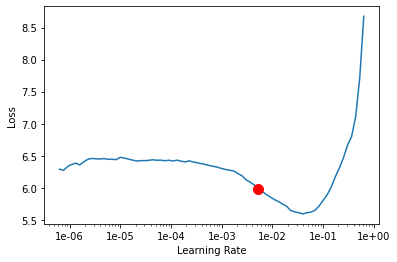

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
lr = learn.recorder.min_grad_lr

The optimized learning rate will correspond to the maximum of the same during the training.

In [15]:
learn.fit_one_cycle(3, max_lr=lr)

### Model Performance

The learning rate along the training can be seen graphically as follows.

In [16]:
learn.recorder.plot()

The accuracy and error rate are displayed below.

In [17]:
m_cifar = learn.recorder.plot_metrics(return_fig=True)
m_cifar.suptitle('Metrics\nCIFAR 100')
plt.show()

The accuracy raises along the training while the error rate decreases as expected.

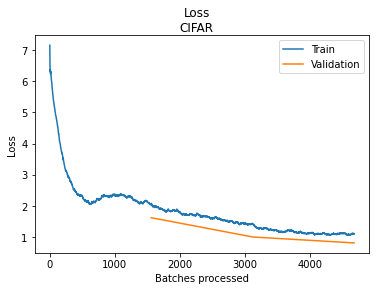

In [18]:
l_cifar = learn.recorder.plot_losses(return_fig=True)
l_cifar.suptitle('Loss\nCIFAR')
plt.show()

The losses (training and validation) along the training examples helped out to conclude that the model is not underfitted nor overfitted.

Other way to check the performance of the model is to carry out Test Time Augmentation, in which the images will be transformed as if they were training examples.

In [19]:
preds, y = learn.TTA()

The accuracy achieved using TTA is shown below.

In [30]:
accuracy(preds, y)

tensor(0.7578)

### Predictions

Other images can be fed to the model in order to predict their respective class as follows.

In [29]:
path_test = Path("./drive/MyDrive/cifar")
il = ImageList.from_folder(path_test)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


cattle


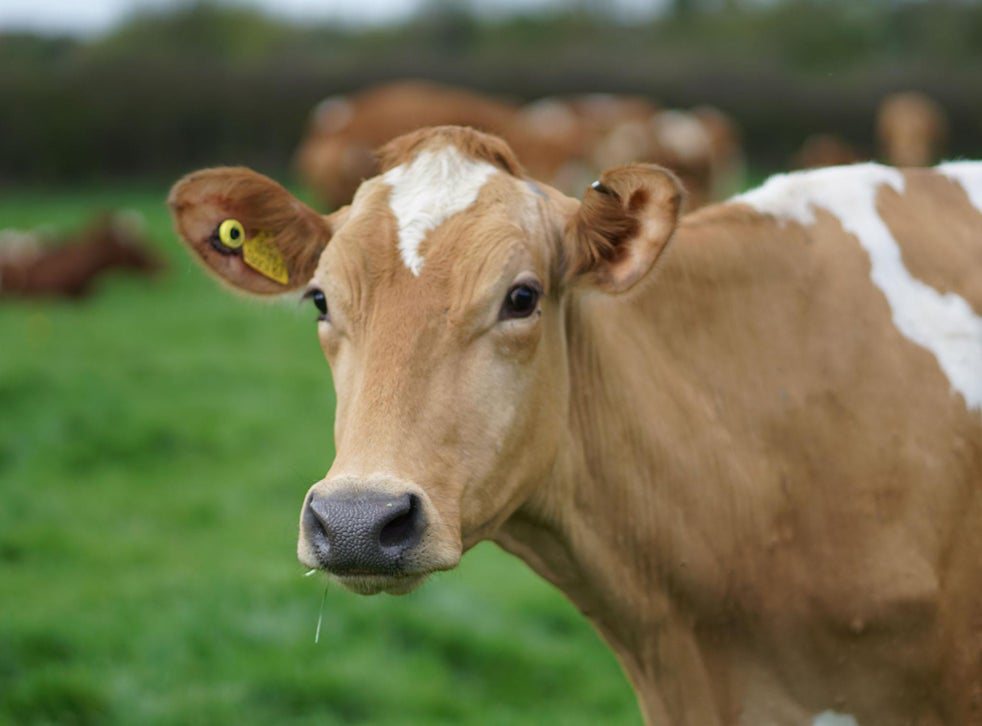

In [22]:
cifar,_,_ = learn.predict(il.open(il.items[0]))
print(cifar)
il.open(il.items[0])

tractor


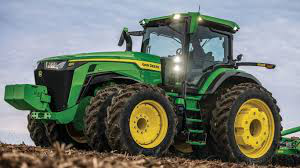

In [23]:
cifar,_,_ = learn.predict(il.open(il.items[1]))
print(cifar)
il.open(il.items[1])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


seal


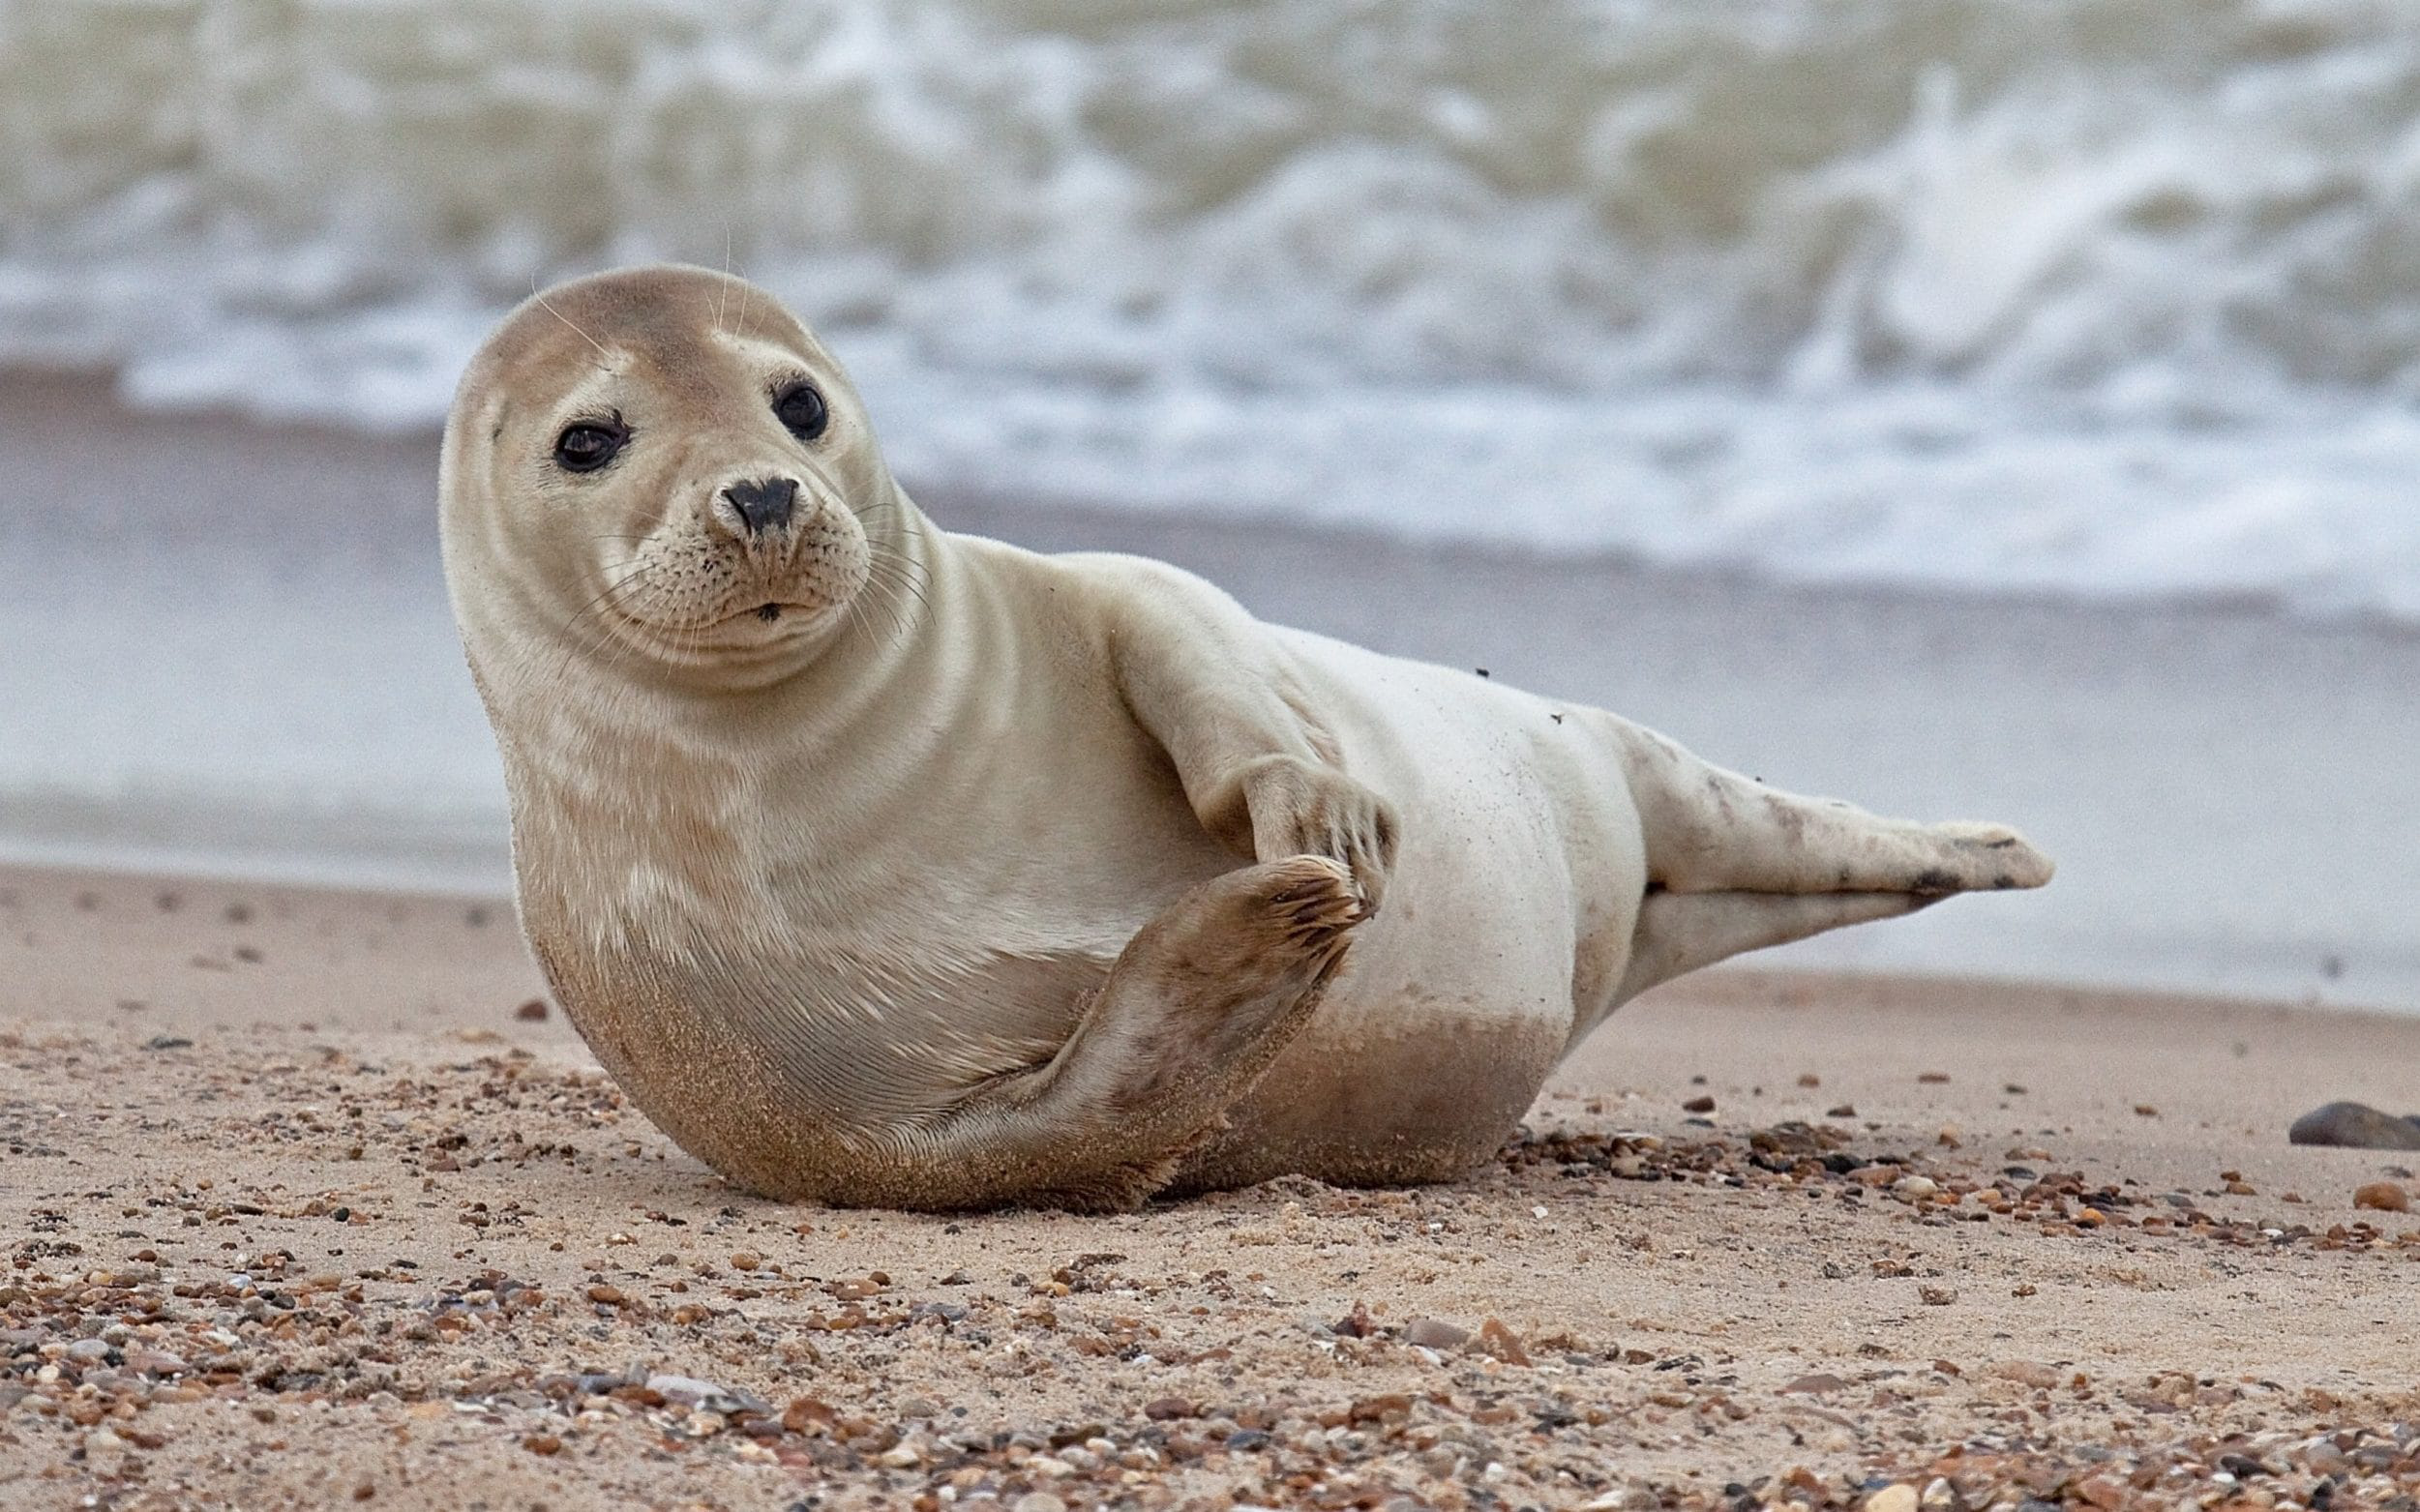

In [31]:
cifar,_,_ = learn.predict(il.open(il.items[2]))
print(cifar)
il.open(il.items[2])

dinosaur


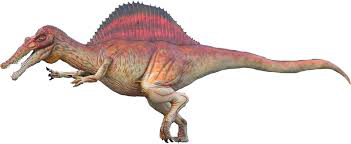

In [32]:
cifar,_,_ = learn.predict(il.open(il.items[3]))
print(cifar)
il.open(il.items[3])